In [1]:
import albumentations as A

import torch

from torchvision import models
from torchvision import transforms as T

from pathlib import Path

from PIL import Image

import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
model = torch.load('/home/enfycius/Documents/LH_Dataset/Semantic_Segmentation/models_v2/Unet.pt')

In [4]:
model.to(device)

Unet(
  (encoder): MobileNetV2Encoder(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kernel_size=(1

In [5]:
import numpy as np
import cv2

import os

In [6]:
def get_files(path):
    files = []
    files_path = []

    for dirname, _, filenames in os.walk(path):
        for filename in filenames:
            files.append(filename)
            files_path.append(dirname + filename)

    return [files, files_path]

In [7]:
def path_to_img(paths, flag=cv2.IMREAD_COLOR):
    imgs = []

    _, paths = get_files(paths)

    for path in paths:
        img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        imgs.append(img)
        
    return [imgs, paths]

In [8]:
def transform_image(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    img_transforms = A.Compose([A.Resize(768, 1152, interpolation=cv2.INTER_NEAREST)])
    aug = img_transforms(image = img)
    img = Image.fromarray(aug['image'])

    ori = img

    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    
    img = t(img)
    img = img.to(device)

    return [img.unsqueeze(0), ori]

In [9]:
def predict_image(img):
    with torch.no_grad():
        output = model(img)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)

    return masked

In [10]:
TEST_PATH = "/home/enfycius/Documents/LH_Dataset/Semantic_Segmentation/sample_v2/"

In [11]:
folders = ["ass", "not_ass"]

In [12]:
imgs_l = []
path_l = []

In [13]:
for folder in folders:
    imgs_l.append(path_to_img(TEST_PATH + folder + "/"))
    path_l.append(folder)

In [14]:
imgs_l

[[[array([[[139, 131, 121],
           [134, 126, 116],
           [139, 131, 121],
           ...,
           [160, 158, 146],
           [160, 157, 148],
           [154, 151, 142]],
   
          [[132, 124, 114],
           [127, 119, 109],
           [131, 123, 113],
           ...,
           [156, 154, 142],
           [157, 154, 145],
           [154, 151, 142]],
   
          [[121, 113, 103],
           [121, 113, 103],
           [128, 120, 110],
           ...,
           [157, 155, 143],
           [158, 155, 146],
           [152, 149, 140]],
   
          ...,
   
          [[150, 146, 137],
           [148, 144, 135],
           [146, 142, 133],
           ...,
           [116, 112, 103],
           [118, 115, 106],
           [119, 116, 107]],
   
          [[148, 143, 137],
           [145, 140, 134],
           [142, 137, 131],
           ...,
           [129, 126, 117],
           [129, 126, 119],
           [119, 116, 109]],
   
          [[147, 142, 136],
        

In [15]:
len(imgs_l[0][0])

55

In [16]:
SAVE_PATH = "/home/enfycius/Desktop/prediction_v2/"

/home/enfycius/anaconda3/envs/enfycius/lib/python3.8/site-packages/torch/nn/modules/conv.py:459: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1682343998658/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


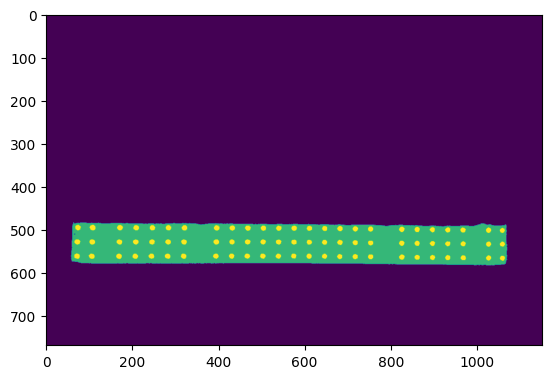

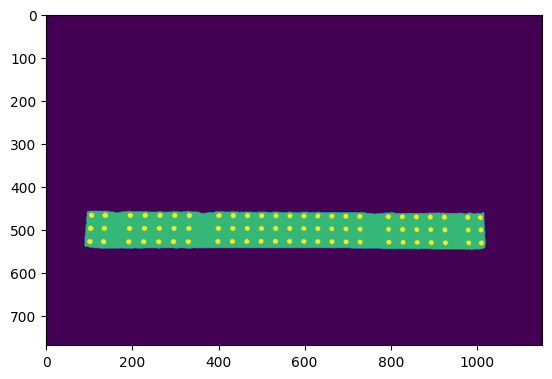

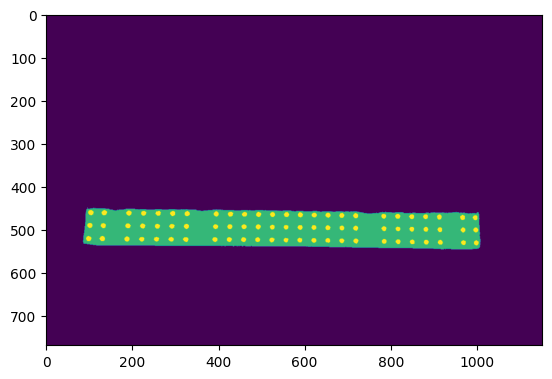

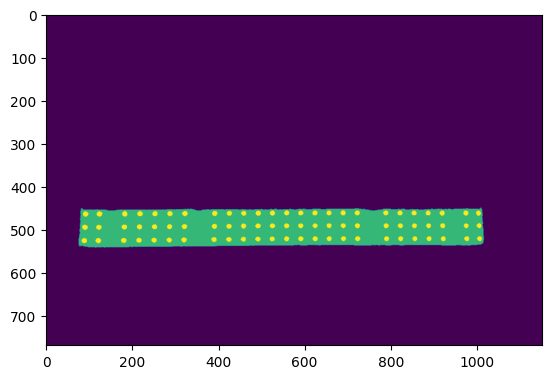

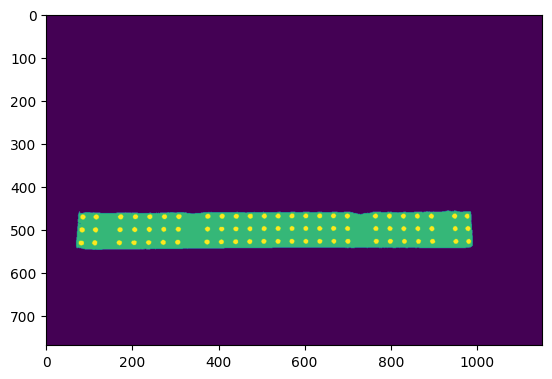

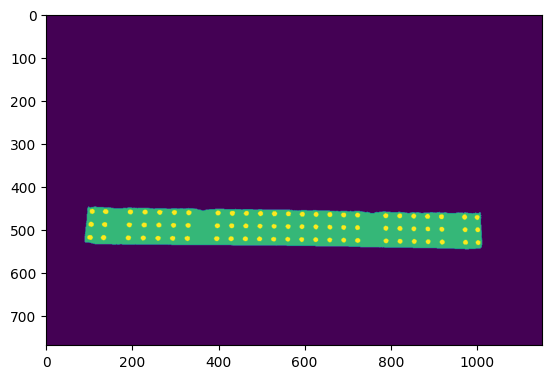

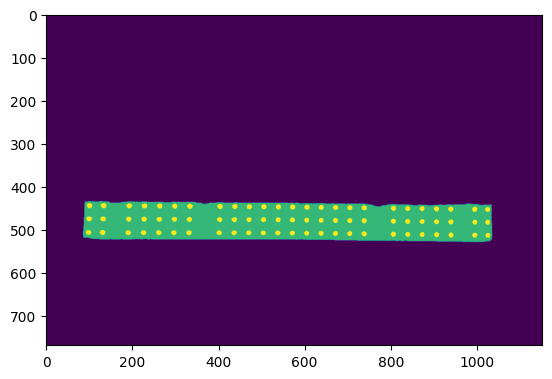

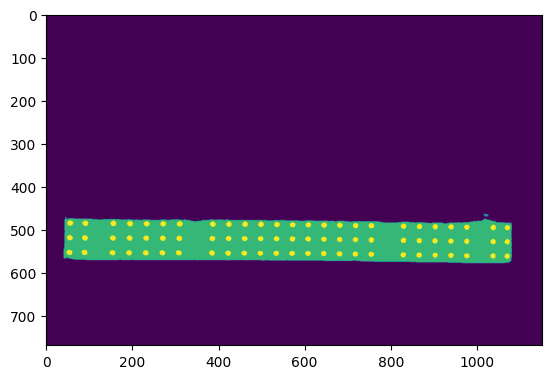

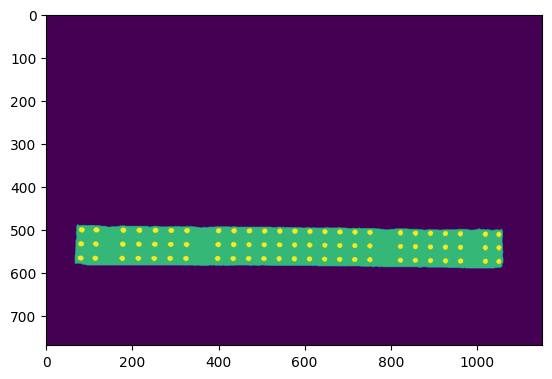

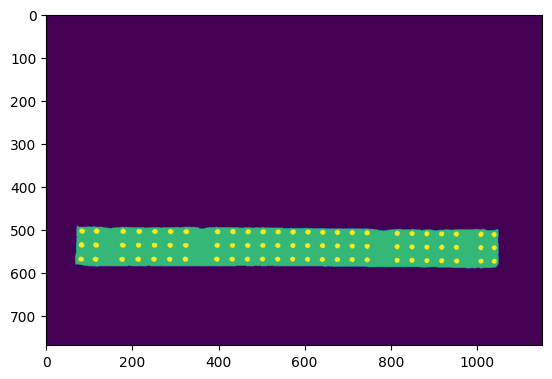

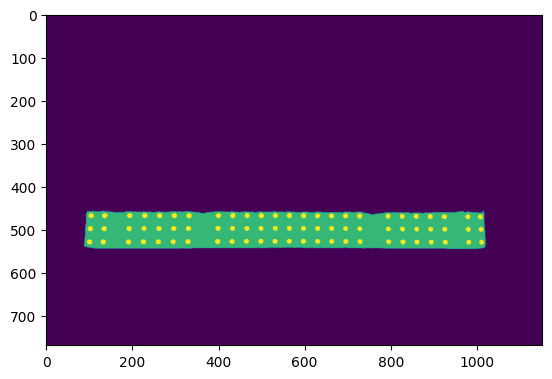

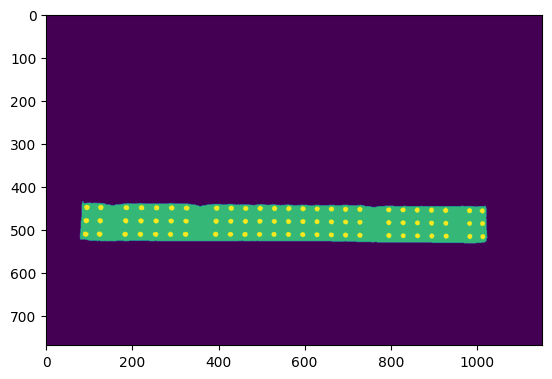

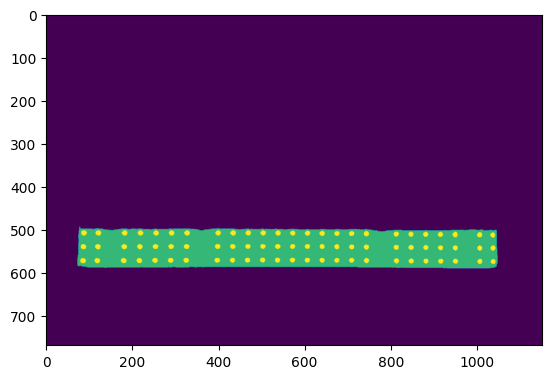

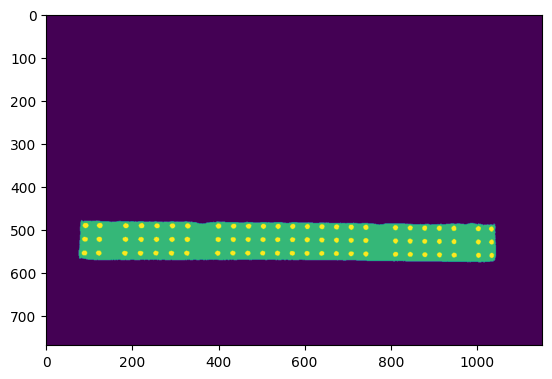

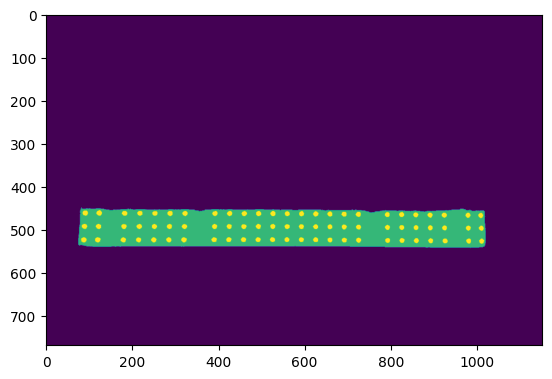

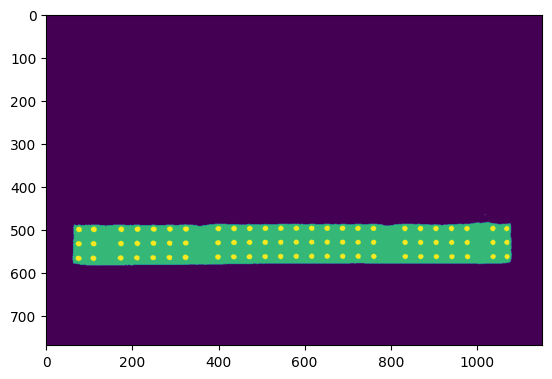

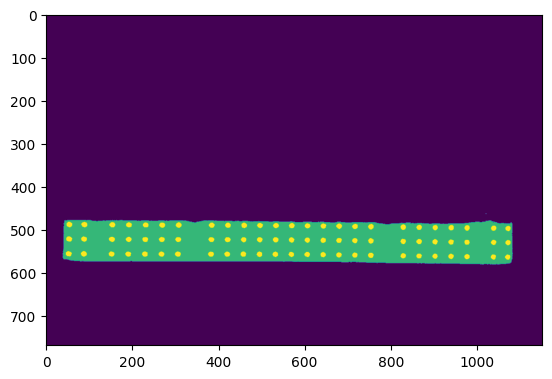

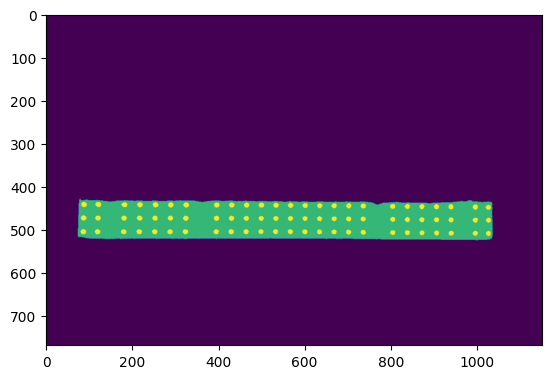

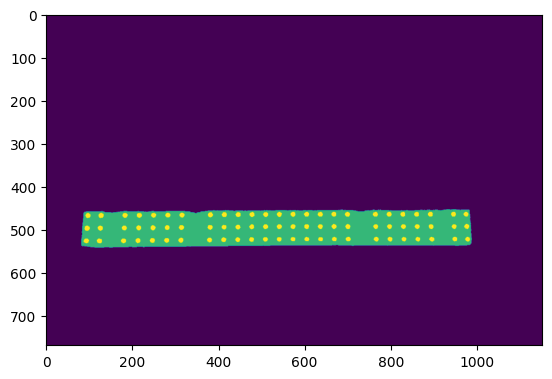

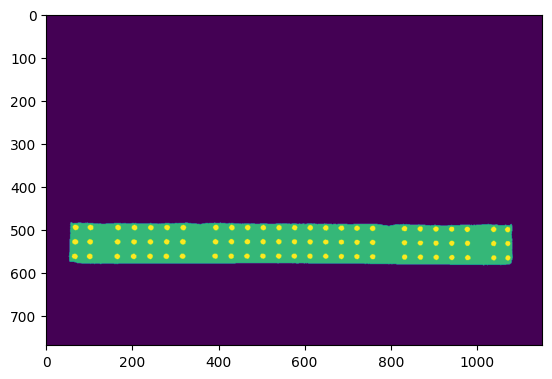

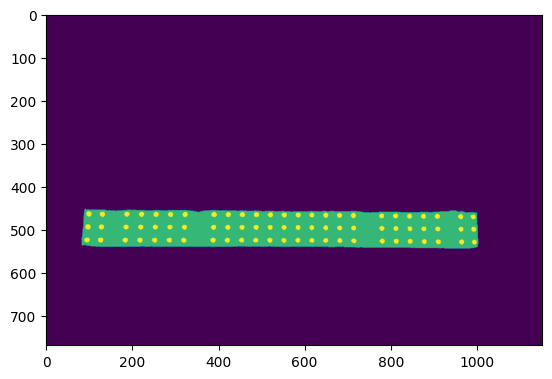

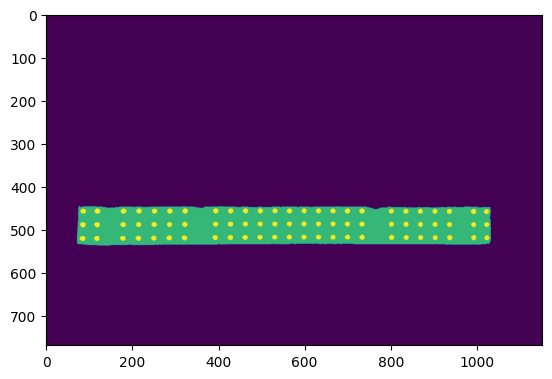

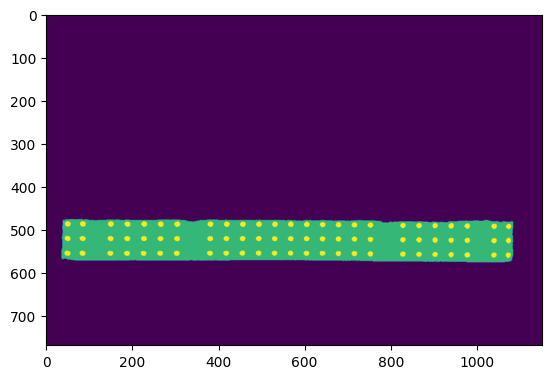

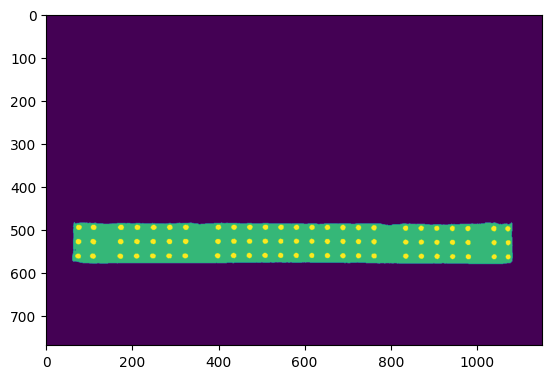

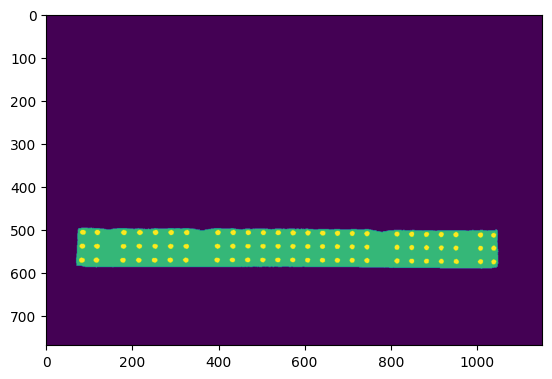

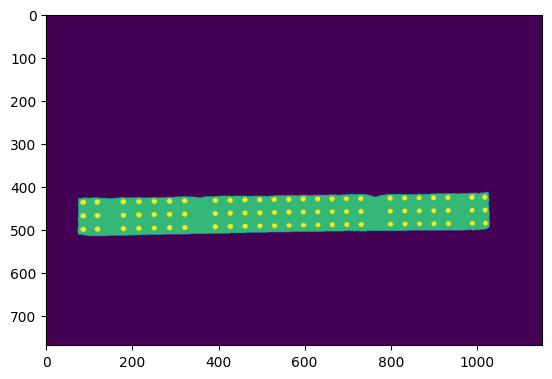

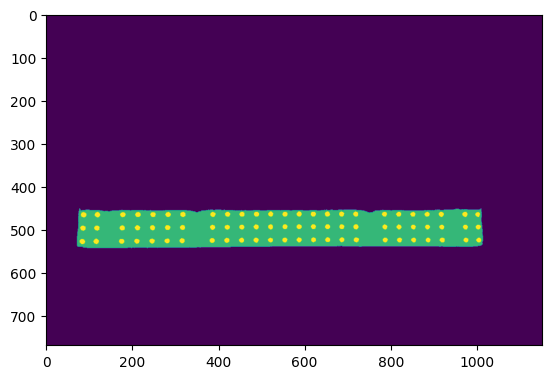

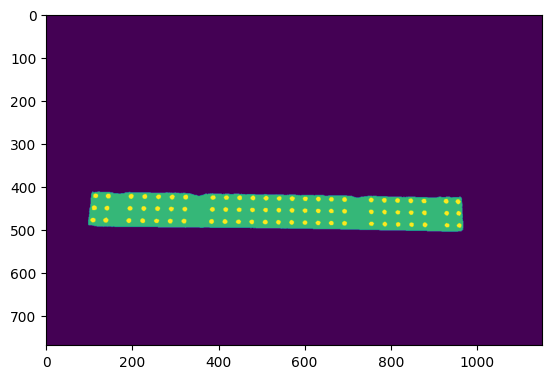

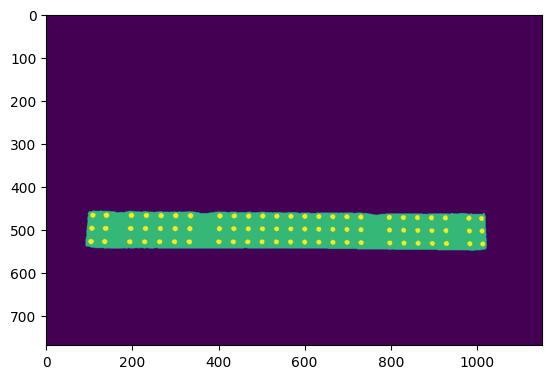

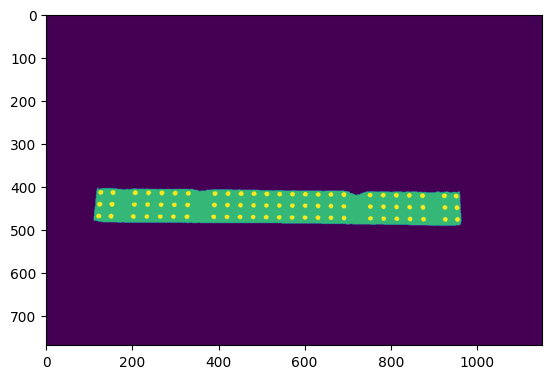

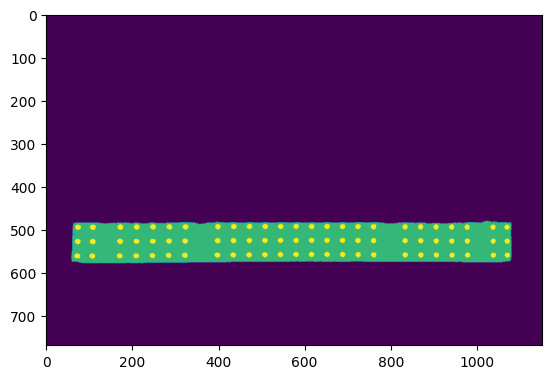

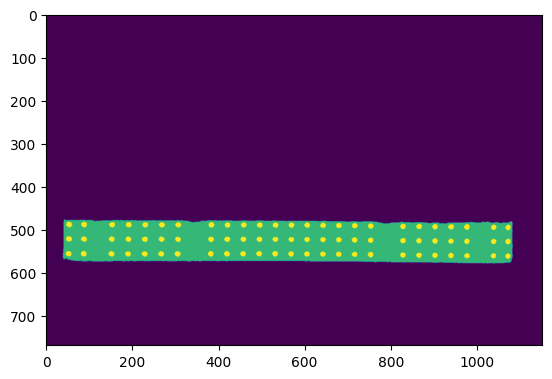

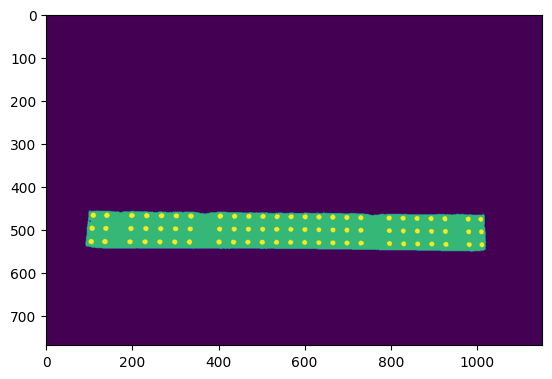

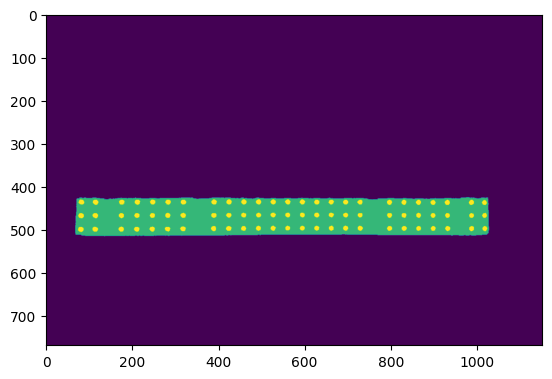

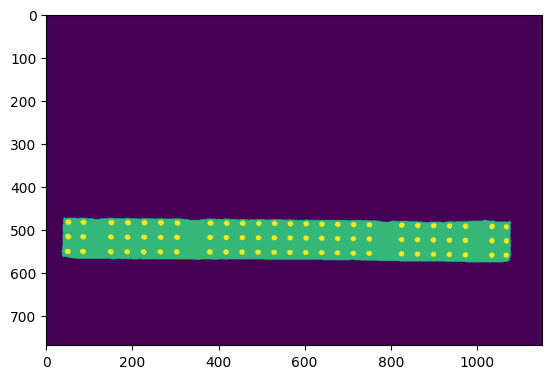

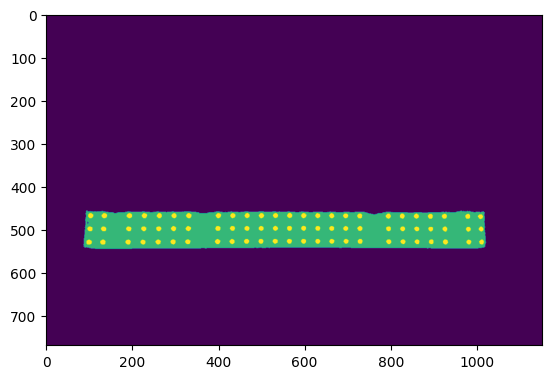

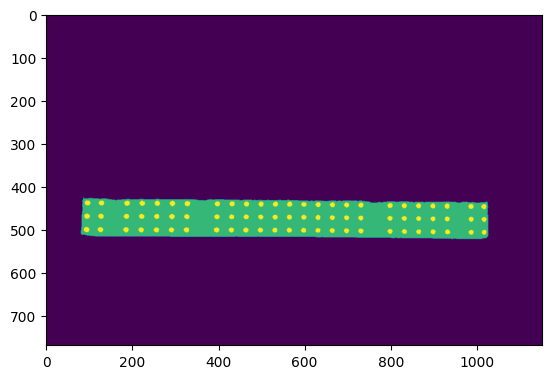

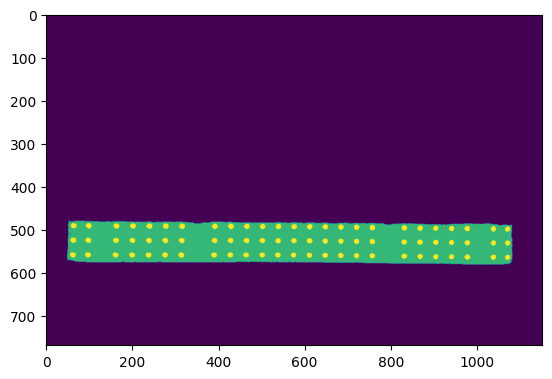

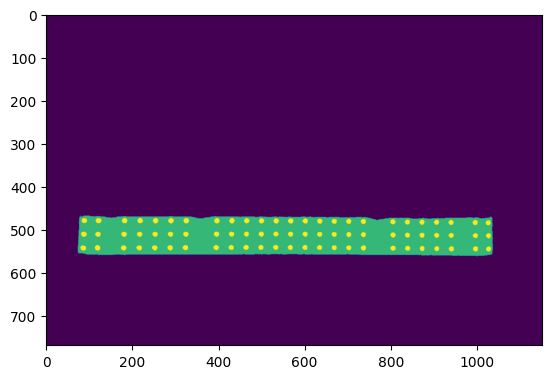

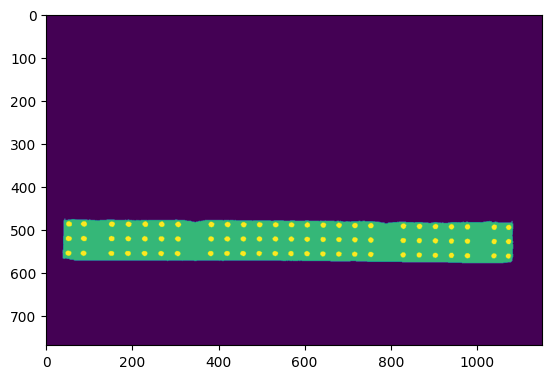

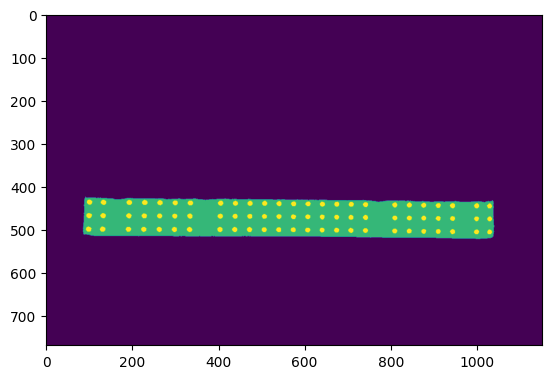

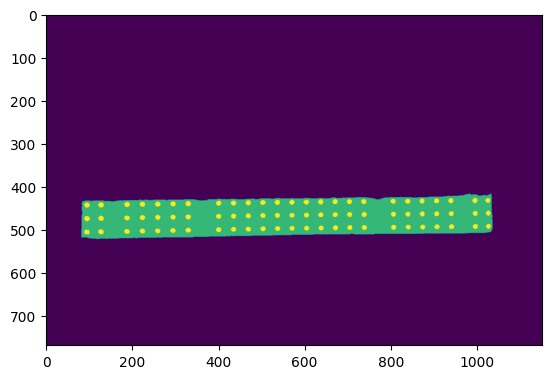

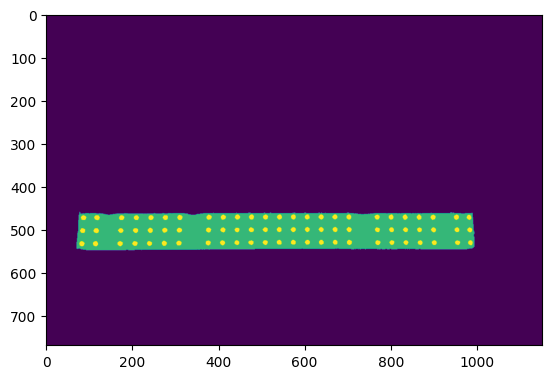

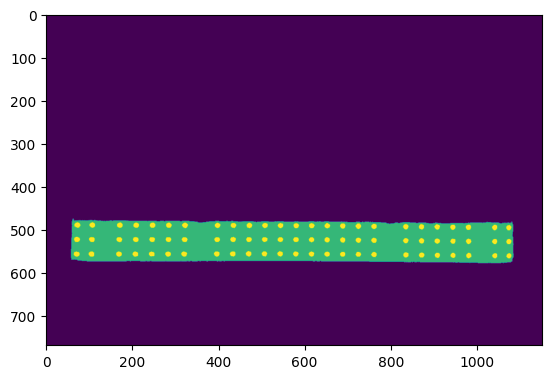

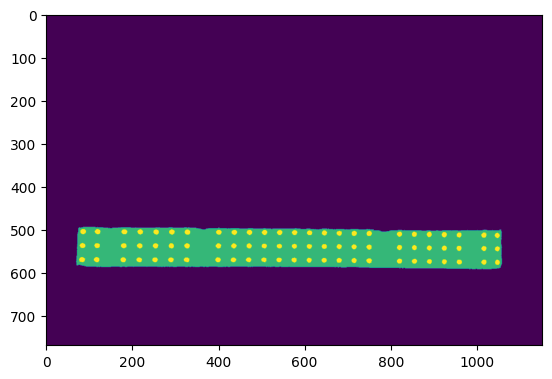

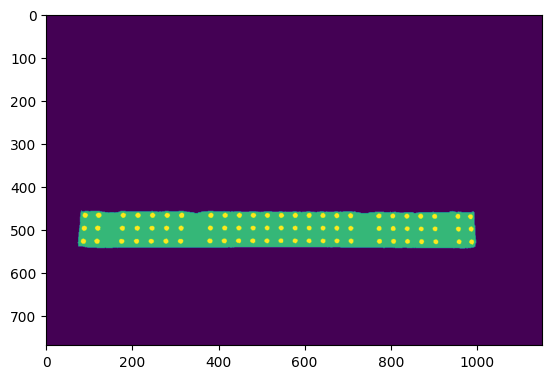

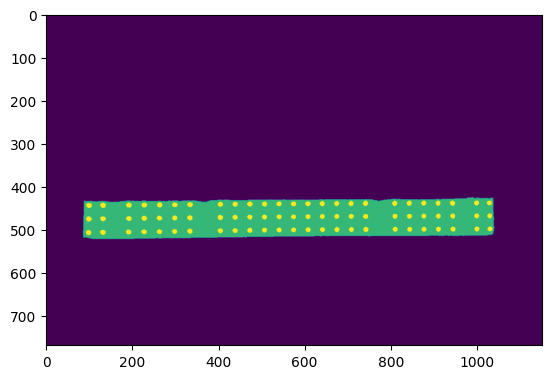

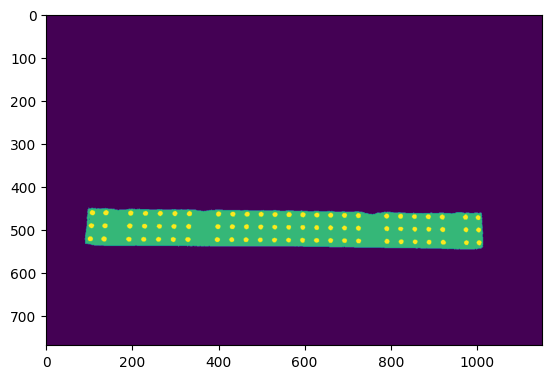

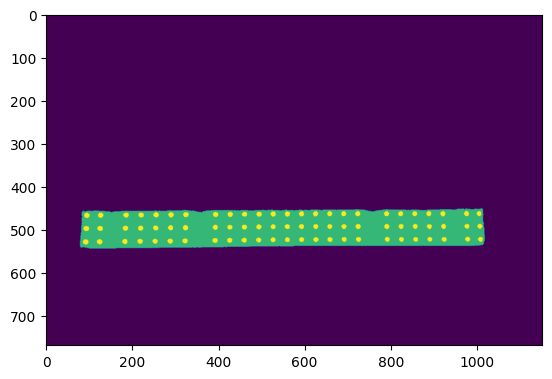

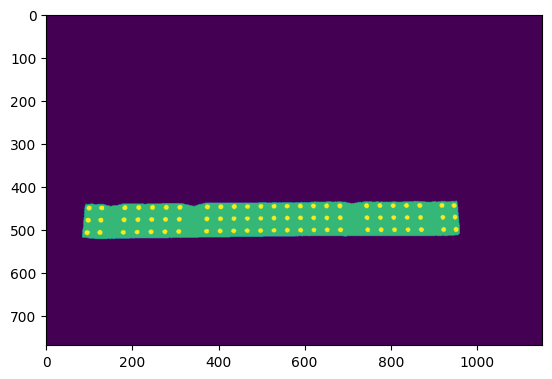

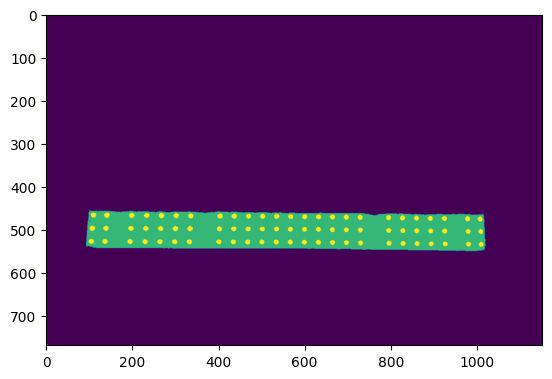

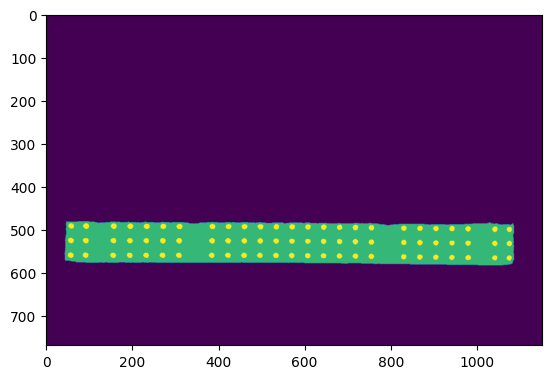

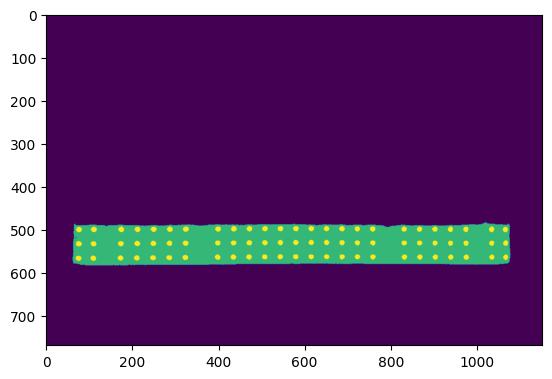

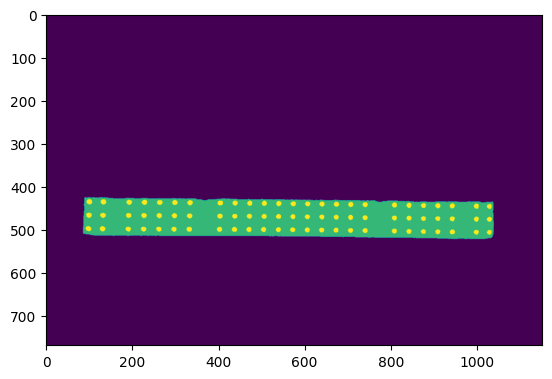

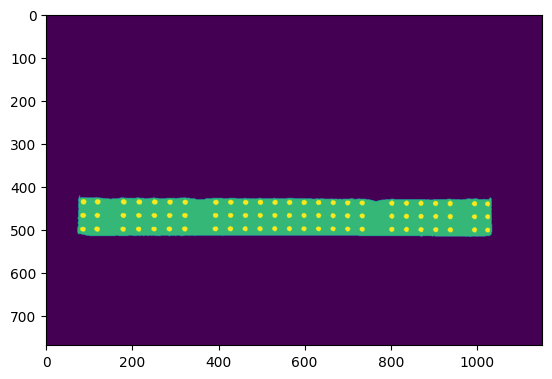

In [17]:
for imgs, folder in zip(imgs_l, path_l):
    if not os.path.exists(SAVE_PATH + folder + "/" + "connection" + "/"):
        os.makedirs(SAVE_PATH + folder + "/" + "connection" + "/")

    if not os.path.exists(SAVE_PATH + folder + "/" + "bolt" + "/"):
        os.makedirs(SAVE_PATH + folder + "/" + "bolt" + "/")

    for img, path in zip(imgs[0], imgs[1]):
        img, _ = transform_image(img)

        masked = predict_image(img).numpy()
        masked = np.float32(masked)

        plt.imshow(masked)
        plt.show()

        _, thresh_1 = cv2.threshold(masked, 1, 128, cv2.THRESH_BINARY)
        _, thresh_2 = cv2.threshold(masked, 2, 255, cv2.THRESH_BINARY)

        cv2.imwrite(SAVE_PATH + folder + "/" + "connection" + '/' + path.split('/')[-1], thresh_1)
        cv2.imwrite(SAVE_PATH + folder + "/" + "bolt" + '/' + path.split('/')[-1], thresh_2)

In [28]:
TRAIN_PATH = "/home/enfycius/Desktop/train_v2/"

In [29]:
import sympy

In [30]:
def appx_best_fit_ngon(mask_cv2, n: int = 4):
    mask_cv2_gray = cv2.cvtColor(mask_cv2, cv2.COLOR_RGB2GRAY)
    
    contours, _ = cv2.findContours(
        mask_cv2_gray, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE
    )

    hull = cv2.convexHull(contours[0])
    hull = np.array(hull).reshape((len(hull), 2))

    hull = [sympy.Point(*pt) for pt in hull]

    while len(hull) > n:
        best_candidate = None

        for edge_idx_1 in range(len(hull)):
            edge_idx_2 = (edge_idx_1 + 1) % len(hull)

            adj_idx_1 = (edge_idx_1 - 1) % len(hull)
            adj_idx_2 = (edge_idx_1 + 2) % len(hull)

            edge_pt_1 = sympy.Point(*hull[edge_idx_1])
            edge_pt_2 = sympy.Point(*hull[edge_idx_2])
            adj_pt_1 = sympy.Point(*hull[adj_idx_1])
            adj_pt_2 = sympy.Point(*hull[adj_idx_2])

            subpoly = sympy.Polygon(adj_pt_1, edge_pt_1, edge_pt_2, adj_pt_2)
            angle1 = subpoly.angles[edge_pt_1]
            angle2 = subpoly.angles[edge_pt_2]

            if sympy.N(angle1 + angle2) <= sympy.pi:
                continue

            adj_edge_1 = sympy.Line(adj_pt_1, edge_pt_1)
            adj_edge_2 = sympy.Line(edge_pt_2, adj_pt_2)
            intersect = adj_edge_1.intersection(adj_edge_2)[0]

            area = sympy.N(sympy.Triangle(edge_pt_1, intersect, edge_pt_2).area)

            if best_candidate and best_candidate[1] < area:
                continue

            better_hull = list(hull)
            better_hull[edge_idx_1] = intersect
            del better_hull[edge_idx_2]
            best_candidate = (better_hull, area)

        if not best_candidate:
            raise ValueError("Could not find the best fit n-gon!")

        hull = best_candidate[0]

    hull = [(int(x), int(y)) for x, y in hull]

    return hull

In [31]:
def order_points(pts):
    rect = np.zeros((4, 2), dtype="float32")

    s = pts.sum(axis = 1)

    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]

    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]

    return rect

In [32]:
def four_point_transform(image, pts):
	rect = order_points(pts)
	(tl, tr, br, bl) = rect

	widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
	widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
	maxWidth = max(int(widthA), int(widthB))

	heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
	heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
	maxHeight = max(int(heightA), int(heightB))

	dst = np.array([
		[0, 0],
		[maxWidth - 1, 0],
		[maxWidth - 1, maxHeight - 1],
		[0, maxHeight - 1]], dtype = "float32")

	M = cv2.getPerspectiveTransform(rect, dst)
	warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

	return warped

In [33]:
def transform_resize(img):
    img_transforms = A.Compose([A.Resize(768, 1152, interpolation=cv2.INTER_NEAREST)])
    aug = img_transforms(image = img)

    img = Image.fromarray(aug['image'])

    return img

In [34]:
def processing(img, connection_label, bolt_label):
    hull = appx_best_fit_ngon(connection_label)
    pts = np.array(hull, dtype = "float32")
    
    ref_img = img
    ref_img = transform_resize(ref_img)
    ref_img = np.array(ref_img)

    ref_bolt_label = bolt_label
    ref_bolt_label = transform_resize(ref_bolt_label)
    ref_bolt_label = np.array(ref_bolt_label)
    
    warped = four_point_transform(ref_img, pts)
    warped_bolt = four_point_transform(ref_bolt_label, pts)

    return [warped, warped_bolt]

In [35]:
radius_mean_sup_lst = []
radius_sup_lst = []

In [39]:
import pandas as pd

In [91]:
bolt_holes_info = pd.DataFrame()

In [61]:
cX_lst = []
cY_lst = []
radius_lst = []

In [62]:
take_capture = True

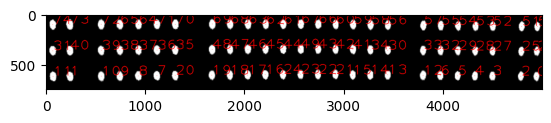

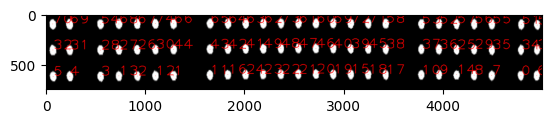

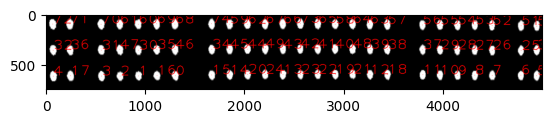

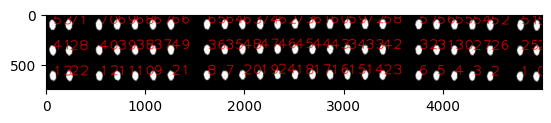

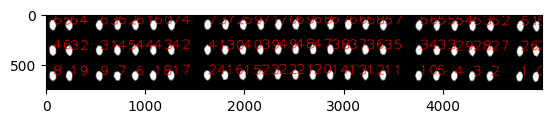

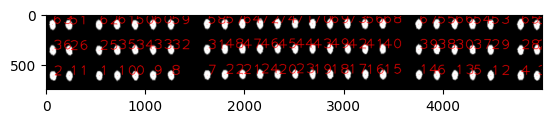

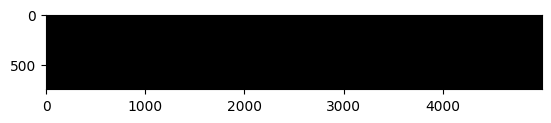

/tmp/ipykernel_533557/3672818579.py:53: RuntimeWarning: Mean of empty slice.
  radius_mean_sup_lst.append(radius_sub_lst.mean())
/home/enfycius/anaconda3/envs/enfycius/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


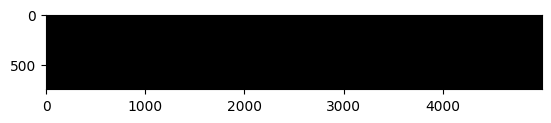

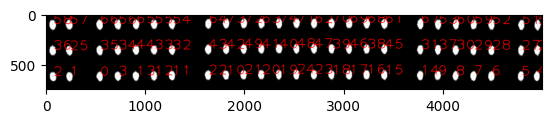

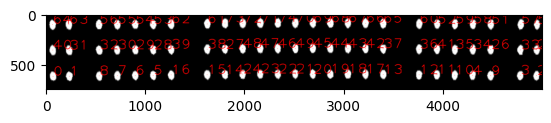

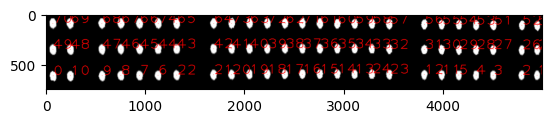

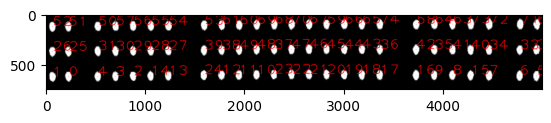

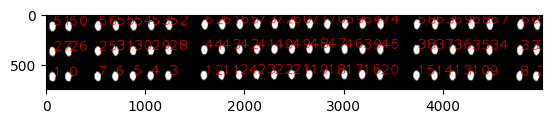

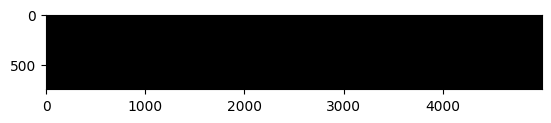

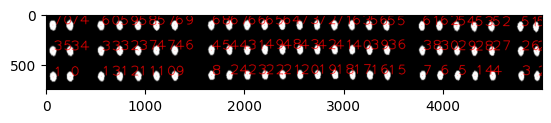

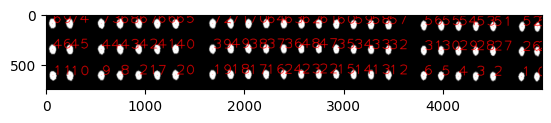

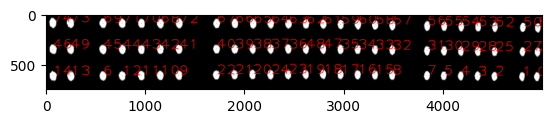

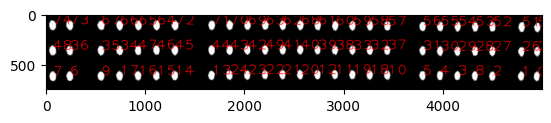

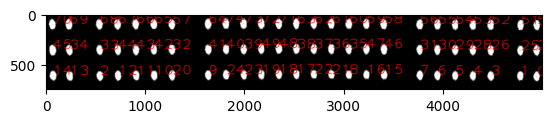

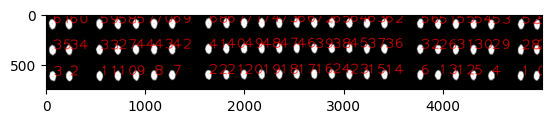

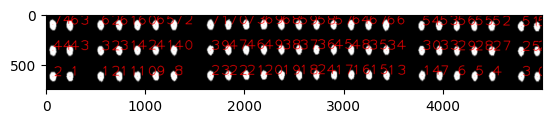

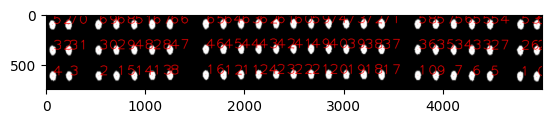

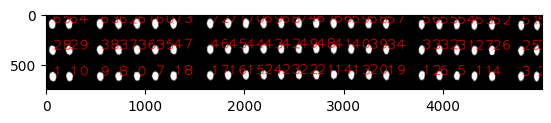

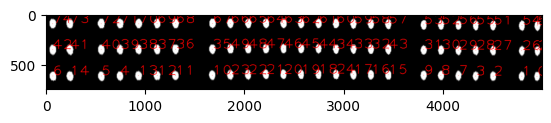

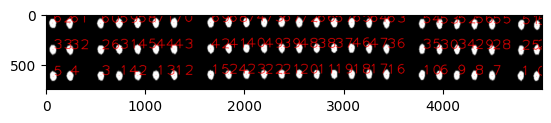

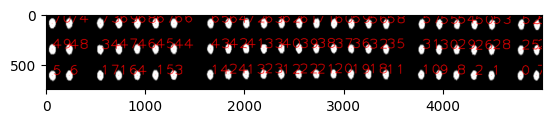

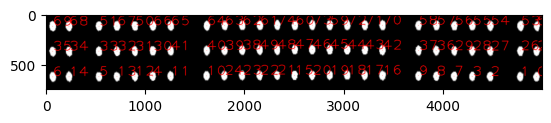

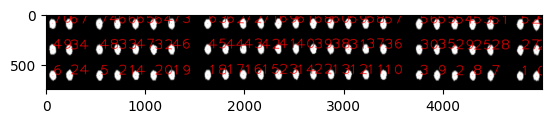

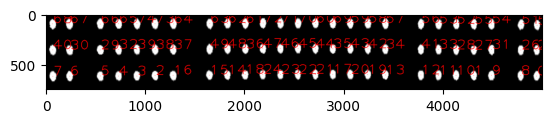

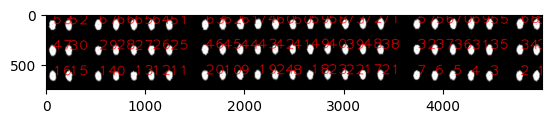

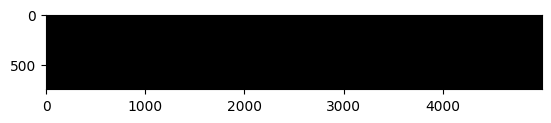

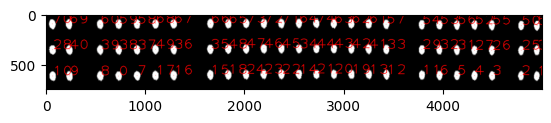

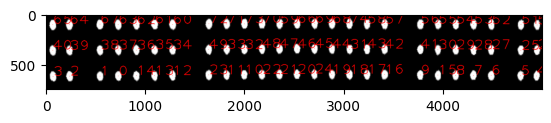

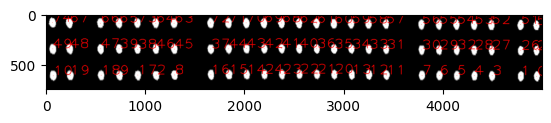

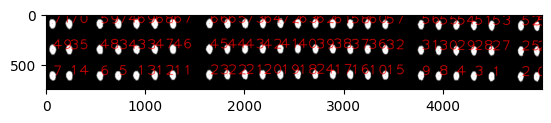

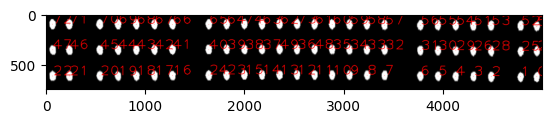

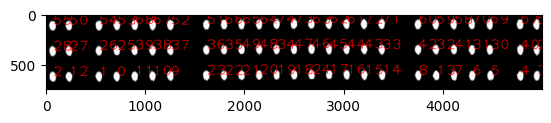

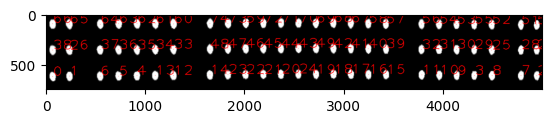

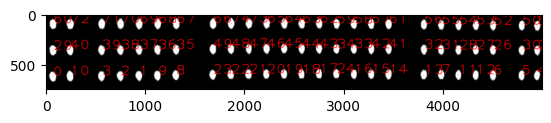

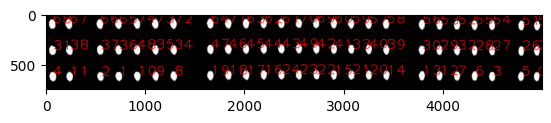

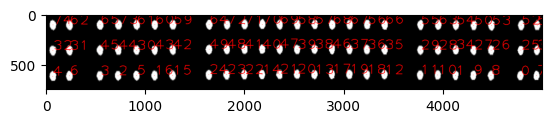

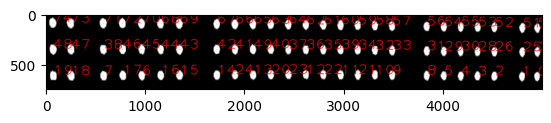

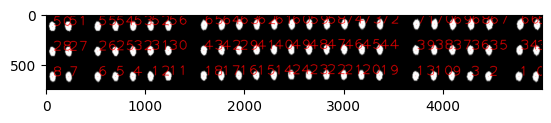

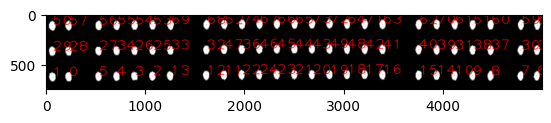

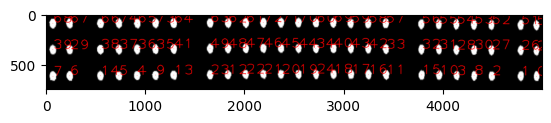

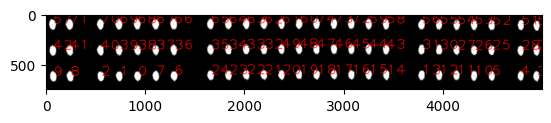

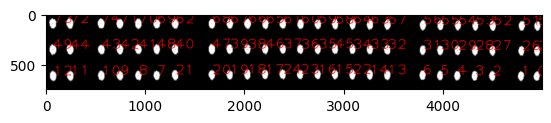

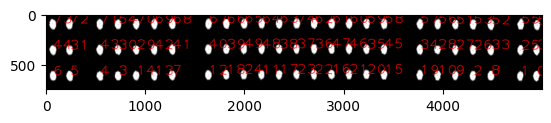

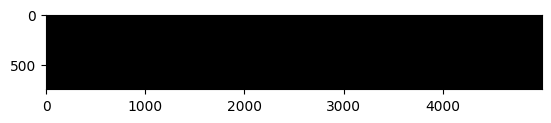

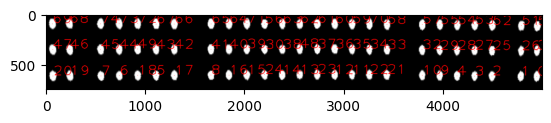

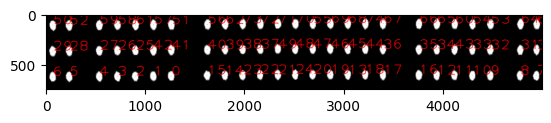

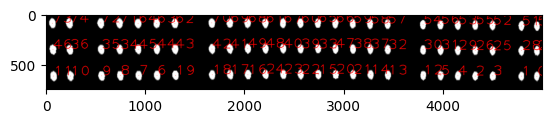

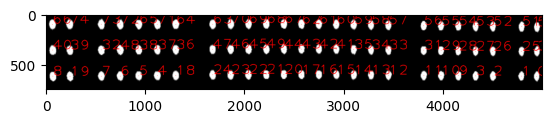

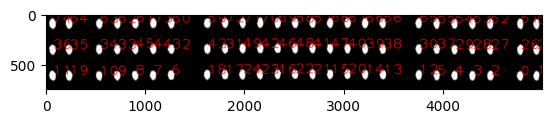

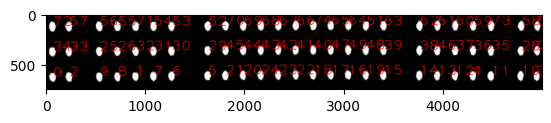

In [63]:
for imgs, folder in zip(imgs_l, path_l):
    _, bolt_img_paths = get_files(SAVE_PATH + folder + "/" + "bolt" + "/")
    _, connection_img_paths = get_files(SAVE_PATH + folder + "/" + "connection" + "/")

    if not os.path.exists(TRAIN_PATH + folder + "/"):
        os.makedirs(TRAIN_PATH + folder + "/")


    for index, (bolt_img_path, connection_img_path) in enumerate(zip(bolt_img_paths, connection_img_paths)):
        img = imgs[0][index]
        bolt_img = cv2.imread(bolt_img_path)
        connection_img = cv2.imread(connection_img_path)
        
        radius_sub_lst = []

        warped, warped_bolt = processing(img, connection_img, bolt_img)

        dst = cv2.resize(warped_bolt, (5000, 750))

        # The below is a modified version.

        dst2 = cv2.cvtColor(dst, cv2.COLOR_RGB2GRAY)

        contours, hierarchy = cv2.findContours(dst2, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        for idx, cnt in enumerate(contours):
            (x, y), radius = cv2.minEnclosingCircle(cnt)
            M = cv2.moments(cnt)
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            # center = (int(x), int(y))
            radius = int(radius)
            # radius_sub_lst.append([cX, cY])
            radius_sub_lst.append(radius)

            if take_capture:
                cX_lst.append(cX)
                cY_lst.append(cY)
                radius_lst.append(radius)

            # cv2.circle(dst, (int(x), int(y)), int(radius), (255,0,0), 2)

            cv2.circle(dst, (cX, cY), 1, (255, 0, 0), 2)
            cv2.putText(dst, str(idx), (cX, cY), cv2.FONT_HERSHEY_PLAIN, 10, (255, 0, 0), 5, cv2.LINE_AA)

        take_capture = False

        plt.imshow(dst)
        plt.show()

        # mean of bolt holes
        radius_sub_lst = np.array(radius_sub_lst)
        radius_mean_sup_lst.append(radius_sub_lst.mean())

        # radius_sub_lst = np.array(radius_sub_lst)

        # radius_not_exist_nan = radius_sub_lst[~np.isnan(np.array(radius_sub_lst))]
        
        # radius_sup_lst.append(radius_sub_lst)

        cv2.imwrite(TRAIN_PATH + folder + "/" + imgs[1][index].split('/')[-1], dst)

In [92]:
bolt_holes_info['centerX'] = cX_lst
bolt_holes_info['centerY'] = cY_lst
bolt_holes_info['radius'] = radius_lst

In [93]:
bolt_holes_info = bolt_holes_info.sort_values(by=['centerY'])

In [97]:
bolt_holes_info

centerX  centerY  radius
67     2568       97      56
69     1676       99      59
66     2743       99      56
68     1854      101      58
73      240      102      60
..      ...      ...     ...
2      4786      621      55
9       743      621      58
10      557      621      59
11       71      623      56
0      4943      625      56

[75 rows x 3 columns]

In [102]:
one_row_bolts = bolt_holes_info[:25].sort_values(by=['centerX'])
two_row_bolts = bolt_holes_info[25:50].sort_values(by=['centerX'])
three_row_bolts = bolt_holes_info[50:].sort_values(by=['centerX'])

In [103]:
one_row_bolts

centerX  centerY  radius
74       68      106      62
73      240      102      60
72      556      102      60
65      744      104      57
64      932      105      57
71     1118      104      60
70     1303      103      61
69     1676       99      59
68     1854      101      58
63     2037      102      57
62     2215      104      56
61     2392      104      56
67     2568       97      56
66     2743       99      56
60     2918      103      55
59     3097      104      56
58     3273      109      58
56     3448      111      56
57     3806      109      59
55     3981      113      57
54     4156      116      58
53     4331      120      56
52     4503      122      56
51     4794      125      58
50     4953      124      52

In [104]:
two_row_bolts

centerX  centerY  radius
31       68      368      57
40      241      362      56
39      557      362      57
38      744      362      55
37      932      362      56
36     1119      361      56
35     1301      358      53
48     1675      354      56
47     1856      354      56
46     2035      353      55
45     2212      353      55
44     2389      352      52
49     2566      349      55
43     2741      350      53
42     2916      352      55
41     3093      355      56
34     3268      360      55
30     3444      363      52
33     3800      361      56
32     3976      363      57
29     4152      366      55
28     4327      370      55
27     4503      371      55
25     4790      371      56
26     4948      370      55

In [105]:
three_row_bolts

centerX  centerY  radius
11       71      623      56
1       241      621      58
10      557      621      59
9       743      621      58
8       930      619      56
7      1118      616      53
20     1302      612      58
19     1671      611      56
18     1852      611      57
17     2031      610      56
16     2209      606      53
24     2388      603      55
23     2564      601      55
22     2740      604      56
21     2916      605      56
15     3090      611      55
14     3266      608      51
13     3444      607      54
12     3801      613      56
6      3976      616      53
5      4149      618      51
4      4322      617      53
3      4500      617      55
2      4786      621      55
0      4943      625      56

In [106]:
# radius_sup_lst

In [ ]:
x = []
y = []

In [ ]:
len(radius_sup_lst)

102

In [ ]:
for radius_sup in radius_sup_lst:
    x = []
    y = []

    for radius_sub in radius_sup[:]:
        if radius_sub:
            print(radius_sub)
            x.append(radius_sub[0])
            y.append(radius_sub[1])

    plt.figure()
    plt.scatter(x, y)
    plt.show()

In [ ]:
len(radius_mean_sup_lst)

39

In [ ]:
radius_mean_sup_array = np.array(radius_mean_sup_lst)

In [ ]:
radius_mean_not_exist_nan = radius_mean_sup_array[~np.isnan(np.array(radius_mean_sup_lst))]

(array([2., 0., 1., 0., 1., 1., 5., 3., 3., 0., 3., 0., 1., 2., 2., 1., 0.,
        2., 3., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
        1., 1., 0., 0., 3.]),
 array([59.77333333, 59.91247863, 60.05162393, 60.19076923, 60.32991453,
        60.46905983, 60.60820513, 60.74735043, 60.88649573, 61.02564103,
        61.16478632, 61.30393162, 61.44307692, 61.58222222, 61.72136752,
        61.86051282, 61.99965812, 62.13880342, 62.27794872, 62.41709402,
        62.55623932, 62.69538462, 62.83452991, 62.97367521, 63.11282051,
        63.25196581, 63.39111111, 63.53025641, 63.66940171, 63.80854701,
        63.94769231, 64.08683761, 64.22598291, 64.36512821, 64.5042735 ,
        64.6434188 , 64.7825641 , 64.9217094 , 65.0608547 , 65.2       ]),
 <BarContainer object of 39 artists>)

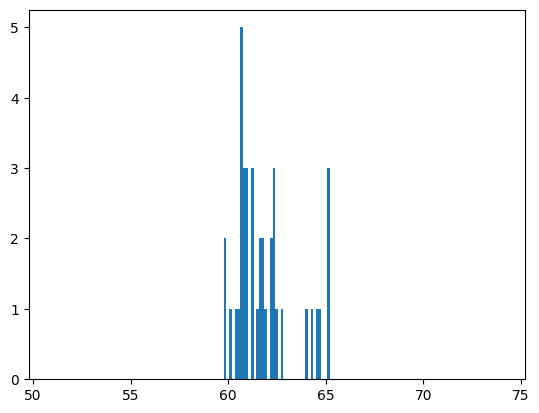

In [ ]:
rng = 10

plt.xlim([min(radius_mean_not_exist_nan) - rng, max(radius_mean_not_exist_nan) + rng])
plt.hist(np.array(radius_mean_not_exist_nan), bins = len(radius_mean_not_exist_nan))

In [ ]:
np.array(radius_mean_not_exist_nan).mean()

61.8728205128205